### the dataset is split into train and test folders with 481 train images and 128 test images 
### the annotations are 68 landmark points which have the x,y coordinates in two columns . The name of the csv file and the images are the same. 




### we first find the centroid of each vertebrae and use that as the labels for training

In [30]:
#!unzip Dataset

In [31]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from skimage import io, transform
import os
import torch
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary
from torchvision import io as tio
from torch.autograd import Variable
from torch import flatten

cudnn.benchmark = True
plt.ion() 

In [32]:
#Image Preprocessing Helper functions

def gamma_correction(img, gamma=1.0):
    gamma_corrected = np.array(255*(img / 255) ** gamma, dtype = 'uint8')
    #gamma_corrected = np.array(img ** gamma)
    return gamma_corrected


def select_gamma(img):
    av = np.average(img)
    gamma = av/30
    return gamma

def apply_clahe(img, limit):
    clahe = cv2.createCLAHE(clipLimit=limit)
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_GRAY2RGB)
    #img = cv2.cvtColor(cv2.COLOR_GRAY2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img = clahe.apply(img)
    return img

def normalize(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))

def preprocess_img(img, num_sections):
    sections = []
    gammas = []
    gamma_corrected_xray = img.copy()

    for i in range(num_sections):
        if i == 0:
            sections.append(gamma_corrected_xray[:int(gamma_corrected_xray.shape[0]/num_sections), :])
        elif i == num_sections-1:
            sections.append(gamma_corrected_xray[int(gamma_corrected_xray.shape[0]*(i)/num_sections+1):, :])
        else:
            sections.append(gamma_corrected_xray[int(gamma_corrected_xray.shape[0]*(i)/num_sections):int(gamma_corrected_xray.shape[0]*(i+1)/num_sections), :])


        gammas.append(select_gamma(sections[i]))
        sections[i] = gamma_correction(sections[i], gammas[i])

        sections[i] = 255*normalize(sections[i])
        #sections[i] = normalize(sections[i])


    for i in range(num_sections):
        gamma_weighted = 255*(gammas[i]/max(gammas))
        #gamma_weighted = (gammas[i]/max(gammas))

        if i == 0:
            gamma_corrected_xray[:int(gamma_corrected_xray.shape[0]/num_sections), :] = sections[i] #255*normalize(((1/gamma_weighted)*img[:int(gamma_corrected_xray.shape[0]/num_sections), :] + gamma_weighted*sections[i])/2)
        elif i == num_sections-1:
            gamma_corrected_xray[int(gamma_corrected_xray.shape[0]*(i)/num_sections+1):, :] = sections[i] #255*normalize(((1/gamma_weighted)*img[int(gamma_corrected_xray.shape[0]*(i)/num_sections+1):, :] +gamma_weighted*sections[i])/2)
        else:
            gamma_corrected_xray[int(gamma_corrected_xray.shape[0]*(i)/num_sections):int(gamma_corrected_xray.shape[0]*(i+1)/num_sections), :] = sections[i] #255*normalize(((1/gamma_weighted)*img[int(gamma_corrected_xray.shape[0]*(i)/num_sections):int(gamma_corrected_xray.shape[0]*(i+1)/num_sections), :] + gamma_weighted*sections[i])/2)
    return gamma_corrected_xray


In [33]:
class Rescale(object):
    """Rescale the image in a sample to a given size. This scales the image AND the corresponding landmarks 

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.num_sections = 100

    def __call__(self, sample):
       
        image_temp, landmarks = sample['image'], sample['landmarks']
        image = preprocess_img(image_temp, self.num_sections)
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img= transform.resize(image, (new_h, new_w))
        
        
        for i in range(len(landmarks)):
            if i % 2 == 0:
               
             # landmarks[i] = landmarks[i] * (new_w / w) 
                landmarks[i] = float(landmarks[i]) * (1 / w) 
           
                
                
            else: 
               #landmarks[i] = landmarks[i] * (new_h / h)
                
                landmarks[i] = float(landmarks[i])  * ( 1 / h )
                
               
            
       
    # here we scale the landmarks between 0 to 1 that is the largest coordinate becomes 1. 
    
    
        return {'image': img, 'landmarks': landmarks}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image': torch.from_numpy(image)[None].float(), 'landmarks': torch.from_numpy(np.float32(landmarks))}

In [34]:
def find_centroid(x1, y1, x2, y2, x3, y3, x4, y4):
    """
    This function takes in the (x,y) coordinates of the four corners of a quadrilateral and returns the (x,y) coordinates of its centroid.
    """
    x_centroid = float((x1 + x2 + x3 + x4) / 4)
    y_centroid = float((y1 + y2 + y3 + y4) / 4)
    return x_centroid, y_centroid

In [35]:
def write_centroids(csv_file):

    
    landmark_frame = pd.DataFrame(pd.read_csv(csv_file, header=None))
    landmark_centroid = list()

    index = 0 
    for rows in range(0,int(len(landmark_frame)/4)):
        x1 = (landmark_frame[0][index])
        x2 = (landmark_frame[0][index + 1])
        x3 = (landmark_frame[0][index + 2])
        x4 = (landmark_frame[0][index + 3])
        y1 = (landmark_frame[1][index])
        y2 =  (landmark_frame[1][index + 1])
        y3 = (landmark_frame[1][index + 2])
        y4 = (landmark_frame[1][index + 3])
        index += 4
        x_centroid,  y_centroid = find_centroid(x1,y1,x2,y2,x3,y3,x4,y4)
        landmark_centroid.append( x_centroid)
        landmark_centroid.append( y_centroid)

    return landmark_centroid

In [36]:
path_training_images = r"Dataset/data/training"
path_training_labels = r"Dataset/Points/training"
images_labels_mapping_training = dict()
for file in os.listdir(path_training_images):
    
    file_name  = os.path.join(path_training_images, file)
    file_name_csv = file+".csv"
    temp = write_centroids(os.path.join(path_training_labels, file_name_csv))
    images_labels_mapping_training[file_name] = temp

In [37]:
image_dir_training = list()
labels_training = list()
for keys, values in images_labels_mapping_training.items():
    image_dir_training.append(keys)
    labels_training.append(values)

In [38]:
print(len(images_labels_mapping_training))
print(len(labels_training))
print(len(image_dir_training))

print(image_dir_training[0])
io.imread(image_dir_training[0])

481
481
481
Dataset/data/training/sunhl-1th-10-Jan-2017-254 A AP.jpg


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 142, 142, 128],
       [  0,   0,   0, ..., 148, 143, 129],
       [  0,   0,   0, ..., 151, 147, 133]], dtype=uint8)

In [39]:
path_testing_images = r"Dataset/data/test"
path_testing_labels = r"Dataset/Points/testing"
images_labels_mapping_testing = dict()
for file in os.listdir(path_testing_images):
    file_name  = os.path.join(path_testing_images,file)
    file_name_csv = file+".csv"
    temp = write_centroids(os.path.join(path_testing_labels, file_name_csv))
    images_labels_mapping_testing[file_name] = temp

In [40]:
image_dir_testing = list()
labels_testing = list()
for keys, values in images_labels_mapping_testing.items():
    image_dir_testing.append(keys)
    labels_testing.append(values)

In [41]:
print(len(images_labels_mapping_testing))
print(len(labels_testing))
print(len(image_dir_testing))
print(image_dir_testing[0])
io.imread(image_dir_testing[0])

128
128
128
Dataset/data/test/sunhl-1th-28-Feb-2017-295 C AP.jpg


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   7,   5,   2],
       [  0,   0,   0, ...,   2,   0,   3],
       ...,
       [199, 199, 199, ..., 187, 187, 187],
       [199, 199, 199, ..., 189, 188, 189],
       [199, 199, 199, ..., 190, 190, 190]], dtype=uint8)

In [42]:
class SpineLandmarksDataset(Dataset):

    def __init__(self,image_dir,labels, transform=None):

        self.landmarks = labels
        self.image_dir = image_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.landmarks) 
        
    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.image_dir[idx]
        image = io.imread(img_name)
        landmarks = np.array(self.landmarks[idx])
        
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [137]:
def show_landmarks(image, landmarks,height,width):
    landmarks = landmarks.cpu().detach().numpy().copy()
    index = 0
    points = list()
    for i in range(0,int(len(landmarks)/2)):
        x_point = landmarks[index]*width
       
        y_point = landmarks[index+1]*height
        
        points.append([x_point, y_point])
        index += 2
    print(points)
    plt.figure(figsize=(10,6))
    
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], marker="o", color="red", s=20)
    #plt.ylim(ymin=0)
    plt.imshow(image[0,:,:],cmap = "gray")
    plt.imshow(image,cmap = "gray")
    plt.show()

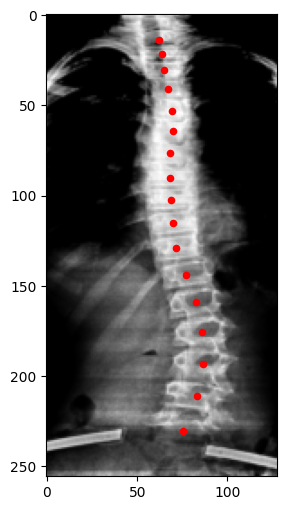

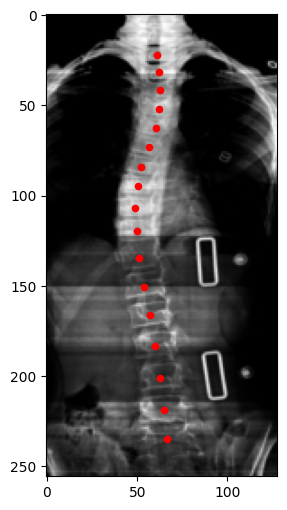

In [44]:
# dataloader are not subscriptable only spine_dataset is subscriptable

height = 256
width = 128
spine_dataset_training = SpineLandmarksDataset(image_dir_training, labels_training, transform=transforms.Compose([Rescale((height,width)),ToTensor()]))
sample = spine_dataset_training.__getitem__(15)
show_landmarks(**sample, height = height, width = width)


spine_dataset_testing = SpineLandmarksDataset(image_dir_testing, labels_testing, transform=transforms.Compose([Rescale((height,width)),ToTensor()]))
sample = spine_dataset_testing.__getitem__(15)
show_landmarks(**sample, height = height, width = width)



In [45]:
#(Classifier for the dataset.
#(Classifier for the dataset.
class SpineNetClassifier(nn.Module):
    
    def __init__(self, classes = 34):
        super(SpineNetClassifier, self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (16,1,256,128) (batch_size, channels, height, width)

        self.Conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=7,stride=1,padding=3)
        #(16,32,256,128)
        self.relu1=nn.ReLU()
        #(16,32,256,128)
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2)
        #(16,32,128,64)

        self.Conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding =1)
        #(16,64,128,64)
        self.relu2=nn.ReLU()
        #(16,64,128,64)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2)
        #(16,64,64,32)

        self.Conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding =1)
        #(16,128,64,32)
        self.relu3=nn.ReLU()
        #(16,128,64,32)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2)
        #(16,128,32,16)

        self.Conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride = 1, padding =2)
        #(16,256,32,16)
        self.relu4=nn.ReLU()
         #(16,256,32,16)
        self.MaxPool4 = nn.MaxPool2d(kernel_size=2)
        #(16,256,16,8)

        self.FC1 = nn.Linear(in_features= 256* 16* 8, out_features=512)
        self.relu5=nn.ReLU()
        self.FC2 = nn.Linear(in_features=512, out_features=512)
        self.relu6=nn.ReLU()
        self.FC3 = nn.Linear(in_features=512, out_features=classes)
        # self.FC4 =  nn.Linear(in_features=512, out_features=classes)


 
    def forward(self,input):
        output = self.Conv1(input)
        output = self.relu1(output)
        output = self.MaxPool1(output)

        output = self.Conv2(output)
        output = self.relu2(output)
        output = self.MaxPool2(output)

        output = self.Conv3(output)
        output = self.relu3(output)
        output = self.MaxPool3(output)

        output = self.Conv4(output)
        output = self.relu4(output)
        output = self.MaxPool4(output)

        output = flatten(output,1)

        output = self.FC1(output)
        output = self.relu5(output)
        output = self.FC2(output)
        output = self.relu6(output)
        output = self.FC3(output)

        return output




In [46]:
#Create an instance of the classifier.
#Classes is 34 Outputs, centroid points for each vertebrae.
device = "cpu" # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [47]:
width = 128
height = 256
model = SpineNetClassifier(classes=34).to(device)
summary(model, input_size=(1,height, width), device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 128]           1,600
              ReLU-2         [-1, 32, 256, 128]               0
         MaxPool2d-3          [-1, 32, 128, 64]               0
            Conv2d-4          [-1, 64, 128, 64]          18,496
              ReLU-5          [-1, 64, 128, 64]               0
         MaxPool2d-6           [-1, 64, 64, 32]               0
            Conv2d-7          [-1, 128, 64, 32]          73,856
              ReLU-8          [-1, 128, 64, 32]               0
         MaxPool2d-9          [-1, 128, 32, 16]               0
           Conv2d-10          [-1, 256, 32, 16]         819,456
             ReLU-11          [-1, 256, 32, 16]               0
        MaxPool2d-12           [-1, 256, 16, 8]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

In [48]:
batch_size = 4
spine_dataset_training = SpineLandmarksDataset(image_dir_training, labels_training, transform=transforms.Compose([Rescale((height,width)),ToTensor()]))
train_dataloader = DataLoader(spine_dataset_training, batch_size, shuffle=True, num_workers = 0)
print(train_dataloader.__len__())

spine_dataset_testing = SpineLandmarksDataset(image_dir_testing, labels_testing, transform=transforms.Compose([Rescale((height,width)),ToTensor()]))
test_dataloader = DataLoader(spine_dataset_testing, batch_size, shuffle=True, num_workers = 0)
print(test_dataloader.__len__())

121
32


In [49]:
print(spine_dataset_training.__getitem__(50)["landmarks"])
arr1 = np.array(spine_dataset_training.__getitem__(50)["landmarks"])
print(spine_dataset_training.__getitem__(100)["landmarks"])
arr2 = np.array(spine_dataset_training.__getitem__(100)["landmarks"])
print(np.std(arr1))
print(np.std(arr2))

tensor([0.4159, 0.0462, 0.4383, 0.0830, 0.4512, 0.1269, 0.4562, 0.1759, 0.4573,
        0.2265, 0.4499, 0.2737, 0.4467, 0.3230, 0.4475, 0.3736, 0.4243, 0.4230,
        0.4037, 0.4751, 0.3937, 0.5310, 0.3924, 0.5925, 0.4227, 0.6556, 0.4633,
        0.7098, 0.5200, 0.7829, 0.5425, 0.8560, 0.5578, 0.9144])
tensor([0.4940, 0.0358, 0.4898, 0.0803, 0.4701, 0.1241, 0.4475, 0.1687, 0.4208,
        0.2150, 0.3951, 0.2615, 0.3935, 0.3054, 0.3972, 0.3528, 0.4239, 0.3974,
        0.4722, 0.4447, 0.5270, 0.4969, 0.5832, 0.5541, 0.6296, 0.6138, 0.6401,
        0.6777, 0.6068, 0.7443, 0.5522, 0.8079, 0.5029, 0.8730])
0.19145359
0.19136092


In [50]:
def custom_loss(output, target):
    loss_MSE = torch.mean((output - target)**2)
    std_target = torch.std(target, dim=1, keepdim=True)
    std_output = torch.std(output, dim=1, keepdim=True)
    lambda_w = 0.3
    loss_std = (std_target - std_output)**2
    combined_loss = (1- lambda_w)*loss_MSE +(lambda_w) *loss_std
    combined_loss = torch.mean(combined_loss)
    return combined_loss

In [51]:
optimizer = Adam(model.parameters(),lr=0.0005) #learning rate
train_loss_epoch = list()  # using these list to see the performance on every epoch
test_loss_epoch = list()
num_epochs = 100
size_train = train_dataloader.__len__()
size_test = test_dataloader.__len__()

In [52]:
#start training and at save the best model for evaluation
for epoch in range(num_epochs): # for every epoch load the entire training data set calculate loss and append per epoch loss
    
    #model training on training dataset
    model.train()
    train_loss=0.0
    
    for batch, sample  in enumerate(train_dataloader):
        optimizer.zero_grad()
        images = sample["image"]
        landmarks = sample["landmarks"]
        # images, landmarks = images.to(device), landmarks.to(device)
#             images=Variable(images.cuda())
#             labels=Variable(labels.cuda())
            
        
        outputs = model(images)
        
        k = outputs
        m = landmarks 
        loss = custom_loss(outputs,landmarks)
        loss.backward()  #back prop
        optimizer.step() 
        
        train_loss += loss.item()
        #train_loss+= loss.cpu().data*images.size(0) #sum the training loss for each image in the batch
    
        
        
    train_loss=train_loss/ size_train #average over all images
    train_loss_epoch.append(train_loss) #append the epoch loss
    f = open("Losses.txt", "a")
    f.write(str(train_loss))
    f.write("\n")
    f.close()
    # Now evaluating on testing dataset
    model.eval()
    
    test_loss = 0.0
    with torch.no_grad():
        for batch, sample  in enumerate(test_dataloader):
            if torch.cuda.is_available():
                images = sample["image"]
                landmarks = sample["landmarks"]
        #             images=Variable(images.cuda())
        #             labels=Variable(labels.cuda())
                # images, landmarks = images.to(device), landmarks.to(device)

            outputs=model(images)
            loss=custom_loss(outputs,landmarks)
            #test_loss+= loss.cpu().data*images.size(0)
          
            test_loss += loss.item()


        

    test_loss = test_loss/size_test
    test_loss_epoch.append(test_loss) #append the epoch loss
    
    print('Epoch: '+str(epoch)+' Training Loss: '+str(np.float64(train_loss))+' Testing Loss: '+str(np.float64(test_loss)))
    f = open("Losses.txt", "a")
    f.write(str(test_loss))
    f.write("\n")
    f.close()
    
    if epoch%20 == 0: 
        path = str(epoch)+"_epochs.pth"
        model_path = os.path.join("models", path) 
        torch.save(model.state_dict(),model_path)
        
    
 
 


/tmp/ipykernel_30740/612139641.py:24: RuntimeWarning: invalid value encountered in divide
  return (img-np.min(img))/(np.max(img)-np.min(img))


Epoch: 0 Training Loss: 0.017874595610047728 Testing Loss: 0.003185390272847144
Epoch: 1 Training Loss: 0.0035197128506169522 Testing Loss: 0.0027835479522764217
Epoch: 2 Training Loss: 0.002816024867525278 Testing Loss: 0.00196380193119694
Epoch: 3 Training Loss: 0.002337225145671886 Testing Loss: 0.001970376151803066
Epoch: 4 Training Loss: 0.002243965063224862 Testing Loss: 0.001932696626681718
Epoch: 5 Training Loss: 0.0019204623507497417 Testing Loss: 0.002114862147209351
Epoch: 6 Training Loss: 0.0018965394730671994 Testing Loss: 0.0017773160579963587
Epoch: 7 Training Loss: 0.0016710835543638173 Testing Loss: 0.0035637088294606656
Epoch: 8 Training Loss: 0.0017680847951911452 Testing Loss: 0.0018526232634030748
Epoch: 9 Training Loss: 0.00162112762841727 Testing Loss: 0.0016704236040823162


In [53]:
torch.save(model.state_dict(),'10_epochs.model')
torch.save(model.state_dict(),'10_epochs.pt')

In [54]:
#best_model = copy.deepcopy(model) # create a deep copy so that all state dictionaries are also saved

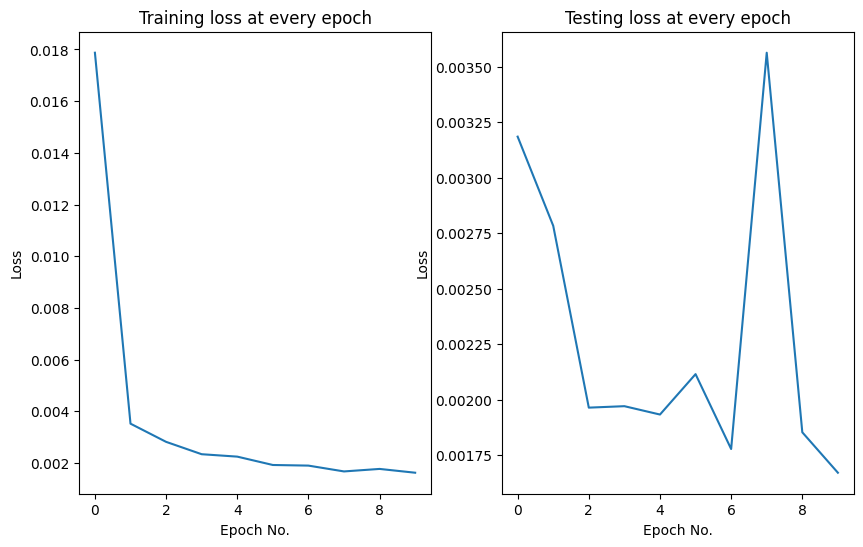

In [55]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_epoch)

plt.xlabel("Epoch No.")
plt.ylabel("Loss")
plt.title("Training loss at every epoch")

plt.subplot(1, 2, 2)
plt.plot(test_loss_epoch)


plt.xlabel("Epoch No.")
plt.ylabel("Loss")
plt.title("Testing loss at every epoch")

plt.show()

Testing the model on a random image

In [190]:
import PIL.Image as Image

In [191]:
def show_results(image, landmarks,height,width):
    landmarks = landmarks.cpu().detach().numpy().copy()
    print(landmarks)
    index = 0
    points = list()
    for i in range(0,int(len(landmarks)/2)):
        x_point = landmarks[index]*width
       
        y_point = landmarks[index+1]*height
        
        points.append([x_point, y_point])
        index += 2
    print(points)
    plt.figure(figsize=(10,6))
    
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], marker="o", color="red", s=20)
    plt.imshow(image,cmap = "gray")
    plt.show()

In [209]:
def centroid_localisation(model, image_transforms, image):

    image = np.array(image) 
    image = preprocess_img(image,200)
    image = Image.fromarray(image)
    image = image_transforms((image)).float()
    image = image.unsqueeze(0)
    results = TempModel(image)       
    landmarks = results.detach().numpy()
    image = image[0,0,:,:]
    show_results(image, results[0], 256,128)
    return  

[0.56885636 0.02940953 0.55014455 0.09737128 0.53246194 0.13020147
 0.5229892  0.18610868 0.50324297 0.24806823 0.48691022 0.29660547
 0.47442457 0.34892136 0.4609547  0.39091077 0.47746867 0.4576092
 0.48094475 0.50620556 0.46739364 0.57108706 0.5041348  0.6222224
 0.5199079  0.6968374  0.5274022  0.747524   0.51495206 0.83130246
 0.49121085 0.8914112  0.527326   0.8119905 ]
[[72.81361389160156, 7.528839588165283], [70.41850280761719, 24.927047729492188], [68.1551284790039, 33.33157730102539], [66.94261932373047, 47.643821716308594], [64.41510009765625, 63.50546646118164], [62.32450866699219, 75.93099975585938], [60.72634506225586, 89.32386779785156], [59.002201080322266, 100.07315826416016], [61.115989685058594, 117.14795684814453], [61.56092834472656, 129.588623046875], [59.826385498046875, 146.1982879638672], [64.52925109863281, 159.2889404296875], [66.54821014404297, 178.390380859375], [67.50748443603516, 191.36614990234375], [65.91386413574219, 212.8134307861328], [62.87498855590

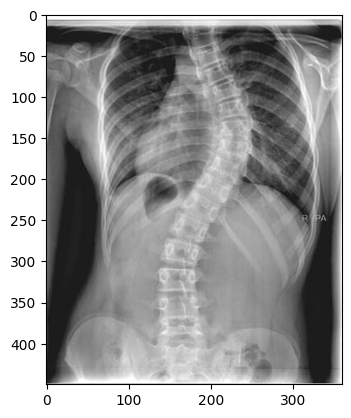

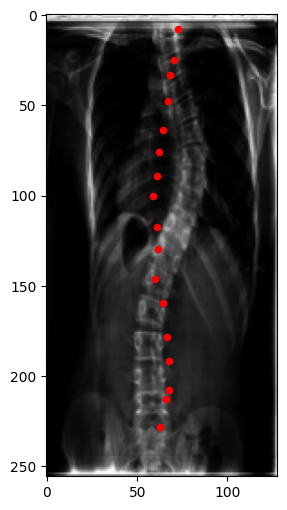

In [215]:
TempModel = SpineNetClassifier()
TempModel.load_state_dict(torch.load(r"10_epochs.pth"))
TempModel.eval()

image_transforms = transforms.Compose([transforms.Resize((256,128)), transforms.ToTensor()])
image_path = r"test2.jpg"
image = (Image.open(image_path).convert('L'))
plt.imshow(image,cmap = "gray")
centroid_localisation(TempModel, image_transforms, image) 

